# Sphering Transform used as Anomaly Detection

An example of using a [sphering transform](https://en.wikipedia.org/wiki/Whitening_transformation) to detect anomalies in CNC vibration data. The data is presented as 30 second windows of acceleration recordings in the `x`, `y` and `z` directions. In this example we are treating the data simply as triplets of observations, not as time series data.

The data was originally collected for the paper:

Tnani, Mohamed-Ali; Feil, Michael; Diepold, Klaus. Smart Data Collection System for Brownfield CNC Milling Machines: A New Benchmark Dataset for Data-Driven Machine Monitoring. *Procedia CIRP2022*,107, 131–136.

* [Repository](https://github.com/boschresearch/CNC_Machining)
* [Paper](https://doi.org/10.1016/j.procir.2022.04.022)

In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# our python modules
from sphering_transform import SpheringTransform
from distribution_diff import DistCalculator, jensen_shannon_divergence

## Read in the data

The original CNC data can be found at the repository link above. 

You can also download a zip file of all the data used in these example notebooks (preprocessed and ready to go) at our Google Drive, [here](https://drive.google.com/drive/folders/1sXtDqNF-D0mypORzfevir_eH9FdG2668). The zip file should include the data preparation scripts as well.


In [2]:
# my local path to the data
datapath = 'data/CNC_machine'

# 30 sec. window of accelerometer data for Machine 1, operation 1, running in a good state
trainingpath = f'{datapath}/goodframe.tsv'

# Another 30 sec windew of data, same machine, same operation
testpathgood = f'{datapath}/alsogood.tsv'

# 30 sec window of data, same machine, same operation, but in a bad state
testpathbad = f'{datapath}/badframe.tsv'

d_train = pd.read_csv(trainingpath, sep='\t')
d_test_good = pd.read_csv(testpathgood, sep='\t')
d_test_bad = pd.read_csv(testpathbad, sep='\t')

## Fit the transform on the training data

Also get the reference distribution of data norms.

In [3]:
# fit the transform on the training data
st = SpheringTransform()
st.fit(d_train)

# transform the training data 
xformed_train = st.transform(d_train)

# calculate the norms of the transformed data -- this is the reference distribution
reference_norms = norm(xformed_train, axis=1)

## Transform the holdout sets and get their norm distributions

In [4]:
xformed_test_good = st.transform(d_test_good)
xformed_test_bad = st.transform(d_test_bad)

goodset_norms = norm(xformed_test_good, axis=1)
badset_norms = norm(xformed_test_bad, axis=1)

## Compare the norm distributions of the observation windows to the reference

The measurements from the "good" run resemble the reference data; the measurements from the "bad" run have a different distribution.

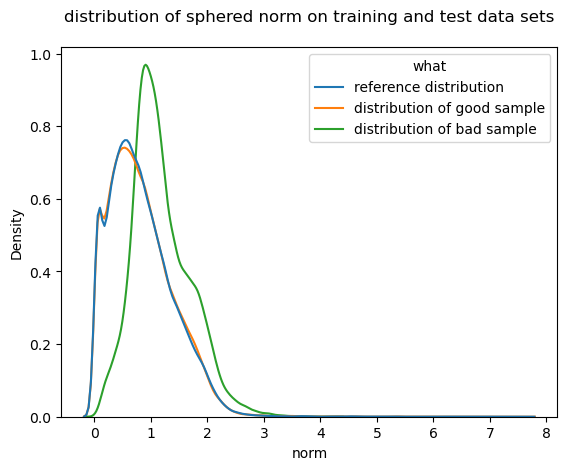

In [5]:
comparison_frame = pd.concat([
    pd.DataFrame({
        'norm': reference_norms,
        'what': "reference distribution",
    }),
    pd.DataFrame({
        'norm': goodset_norms,
        'what': "distribution of good sample",
    }),
    pd.DataFrame({
        'norm': badset_norms,
        'what': "distribution of bad sample",
    })
])

sns.kdeplot(
    data=comparison_frame,
    x="norm",
    hue="what",
    common_norm=False,
)
plt.title("distribution of sphered norm on training and test data sets\n")
plt.show()

### Difference of Distributions (PSI)

We can also measure the difference quantitatively using the Population Stability Index (or your preferred distribution divergence metric).

This PSI calculator uses decile binning. A common rule of thumb:

* PSI < 0.1: distributions are similar
* PSI between 0.1 and 0.25: distributions are somewhat different
* PSI > 0.25: distributions are very different


In [6]:
# create a PSI calculator to measure differences from reference norm distribution
psiCalc = DistCalculator(reference_norms)

{
    'PSI_good': psiCalc.PSI(goodset_norms),
    'PSI_bad' : psiCalc.PSI(badset_norms)
}

{'PSI_good': 0.0004383462900697606, 'PSI_bad': 0.7460317407918826}

In [7]:
{
    'JSD_good': jensen_shannon_divergence(reference_norms, goodset_norms),
    'JSD_bad' : jensen_shannon_divergence(reference_norms, badset_norms)
}

{'JSD_good': 7.743909532043568e-05, 'JSD_bad': 0.11490298374555996}

## What does it look like in real space?

One could also try simply monitoring the norms of the vibration data without sphere-transforming. Here we see what that looks like, for comparison.

In [8]:
# calculate the norm distributions in the original measurement space

reference_norms = norm(d_train, axis=1)
goodset_norms = norm(d_test_good, axis=1)
badset_norms = norm(d_test_bad, axis=1)

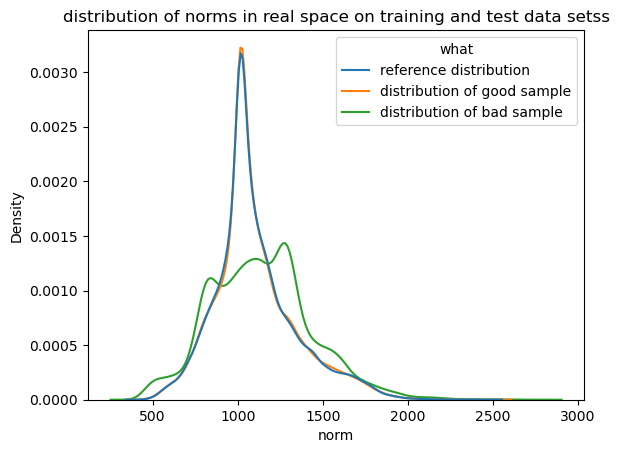

In [9]:
comparison_frame = pd.concat([
    pd.DataFrame({
        'norm': reference_norms,
        'what': "reference distribution",
    }),
    pd.DataFrame({
        'norm': goodset_norms,
        'what': "distribution of good sample",
    }),
    pd.DataFrame({
        'norm': badset_norms,
        'what': "distribution of bad sample",
    })
])

graph = sns.kdeplot(
    data=comparison_frame,
    x="norm",
    hue="what",
    common_norm=False,
)

plt.title("distribution of norms in real space on training and test data setss")
plt.show()

In [10]:
psiCalc = DistCalculator(reference_norms)

{
    'PSI_good': psiCalc.PSI(goodset_norms),
    'PSI_bad' : psiCalc.PSI(badset_norms)
}

{'PSI_good': 0.0007404046931391623, 'PSI_bad': 0.25471400678107975}

In [11]:
{
    'JSD_good': jensen_shannon_divergence(reference_norms, goodset_norms),
    'JSD_bad' : jensen_shannon_divergence(reference_norms, badset_norms)
}

{'JSD_good': 0.00014244516326817507, 'JSD_bad': 0.04422778141370939}

The vibration measurements of the machine operation running in a bad state are noticeably different from reference even in the original space, but note that the PSI divergence of the bad data is three times larger in the transformed space. This suggests that monitoring the vibration data in sphere-transformed coordinates could a more sensitive anomaly detector. Of course, for a real application a more in-depth study (and more measurements) would be required.